<a href="https://colab.research.google.com/github/aldysp34/Music-Classification-and-Recommendation/blob/master/music_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Machine Learning Klasfikasi dan Sistem Rekomendasi Musik**
_Oleh :_
1. *M299R5310 - Muhammad Aldi Surya Putra*
2. *M014V6060 - Ayu Kadek Nadya Oktaviana*

## **1. Import Library**

In [1]:
! pip install opendatasets
# Usual Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import scipy
import pickle
import tensorflow as tf
from tqdm import tqdm

# Download Dataset
import opendatasets as od 

# Audio Library
import librosa
import librosa.display
import IPython.display as ipd

# Classification Library
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

## **2. Download Dataset**

In [2]:

od.download("https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aldysp34
Your Kaggle Key: ··········


100%|██████████| 1.21G/1.21G [00:13<00:00, 99.3MB/s]


## **3. Dataset**

In [3]:
# Inisialisasi Path Dataset
general_path = '/content/gtzan-dataset-music-genre-classification/Data'

In [4]:
# Read data Genre
audio_data = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'
print(list(os.listdir(audio_data)))
print('\n')

# Read Metada
metadata = pd.read_csv(f'{general_path}/features_30_sec.csv')
metadata.head()

['blues', 'jazz', 'country', 'rock', 'reggae', 'metal', 'disco', 'classical', 'pop', 'hiphop']




,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
# Informasi kolom pada dataset
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

Text(0, 0.5, 'BPM')

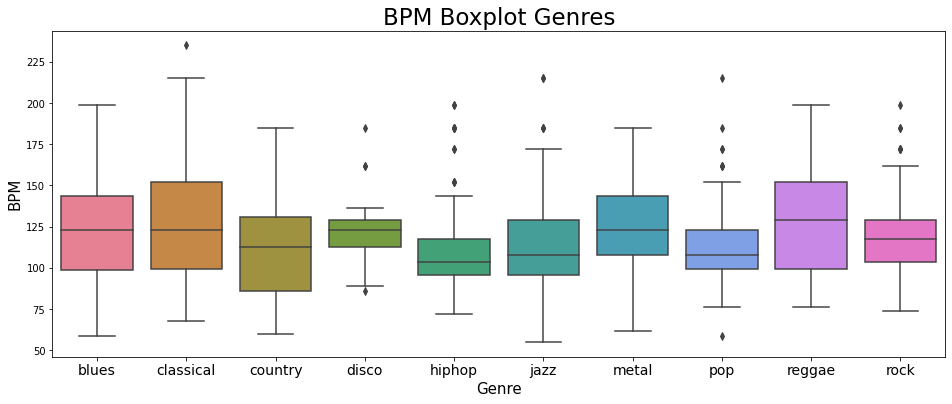

In [6]:
# Distribusi Box-Plot Genre
x = metadata[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 6));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot Genres', fontsize = 23)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

## **3. Explore Data Audio**

In [7]:
# Analisis satu sampel audio
data , sr = librosa.load(f'{general_path}/genres_original/pop/pop.00003.wav')

# Cek tipe data
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [8]:
# Keterangan audio
print('Data\t\t\t: ', data)
print('Data Shape\t\t: ', np.shape(data))
print('Sample Rate (KHz)\t: ', sr)

# Panjang audio
print('\nPanjang Audio\t\t:', librosa.get_duration(data))

Data			:  [-0.0249939  -0.01815796 -0.02023315 ... -0.36505127 -0.4237976
 -0.42385864]
Data Shape		:  (661504,)
Sample Rate (KHz)	:  22050

Panjang Audio		: 30.00018140589569


In [9]:
# Memutar audio
ipd.Audio(data, rate=sr)

### **3.1 _Audio Representation_**

#### **1. Sound Waves**

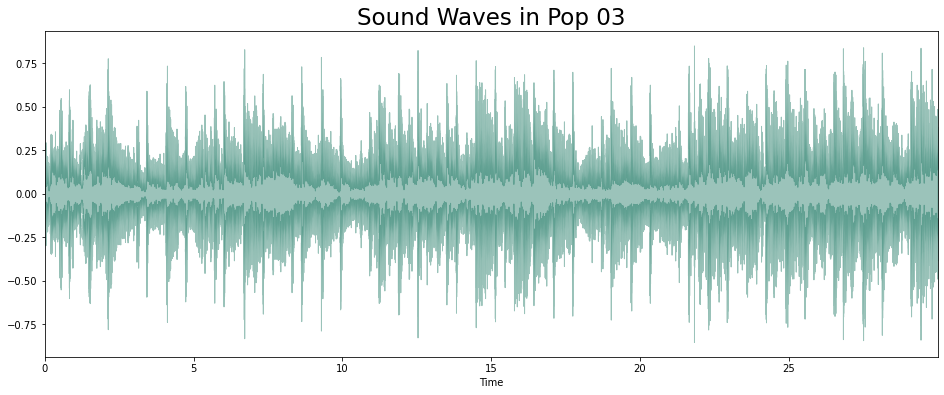

In [10]:
# Waveform Audio
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = data, sr = sr, alpha = 0.4, color = "#066B54");
plt.title("Sound Waves in Pop 03", fontsize = 23);

#### **2. Spectogram**

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


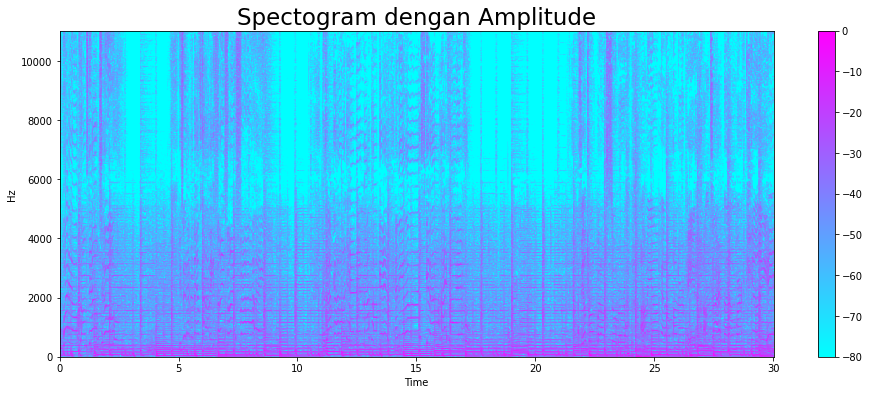

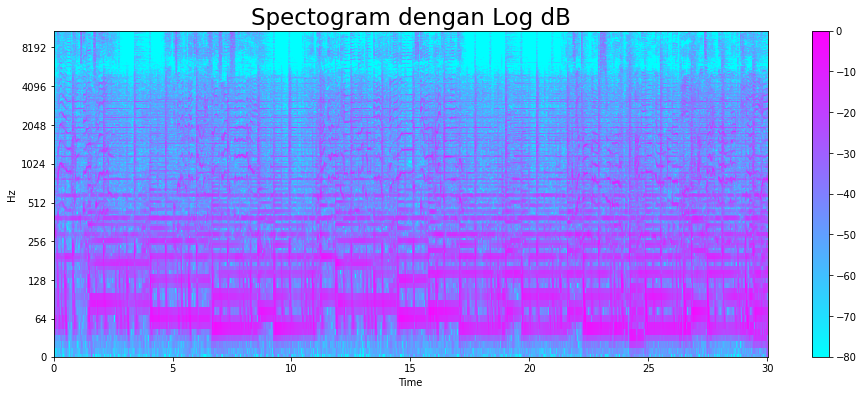

In [11]:
# Short-time Fourier Transform (STFT)
stft = librosa.stft(data, n_fft=2048, hop_length=512)

# Konversi amplitude spectogram menjadi dB-scaled spectogram
stft_db = librosa.amplitude_to_db(stft, ref = np.max)

# Menampilkan spectogram dengan amplitude
plt.figure(figsize = (16, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz', cmap ='cool')

plt.colorbar()
plt.title("Spectogram dengan Amplitude", fontsize = 23)
plt.show()

# Menampilkan spectogram dengan log dB
plt.figure(figsize = (16, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'log', cmap ='cool')

plt.colorbar()
plt.title("Spectogram dengan Log dB", fontsize = 23)
plt.show()

#### **3. Mel Spectogram**

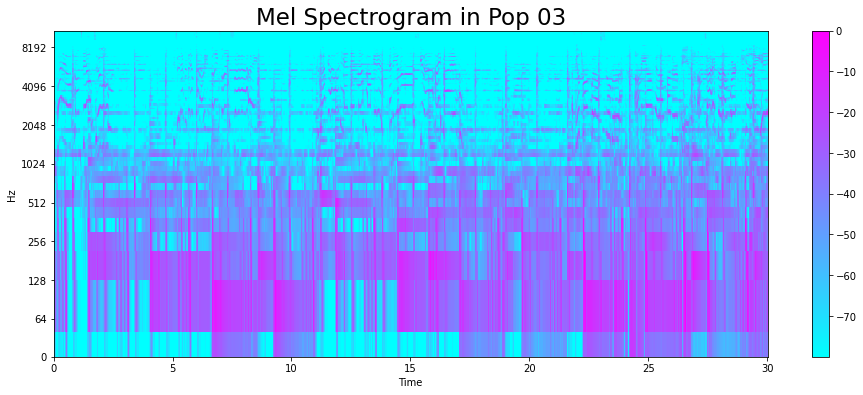

In [12]:
# Konversi mel spectogram
Mel = librosa.feature.melspectrogram(data, sr = sr)
Mel_dB = librosa.amplitude_to_db(Mel, ref = np.max)

# Menampilkan Mel Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(Mel_dB, sr = sr, x_axis = 'time', y_axis = 'log', cmap = 'cool');

plt.colorbar();
plt.title("Mel Spectrogram in Pop 03", fontsize = 23);

### **3.2 _Audio Features_**

#### **1. Tempo BMP (Beats Per Minute)**

In [13]:
# Tempo BPM
tempo, _ = librosa.beat.beat_track(data, sr = sr)
tempo

92.28515625

#### **2. Spectral Features**

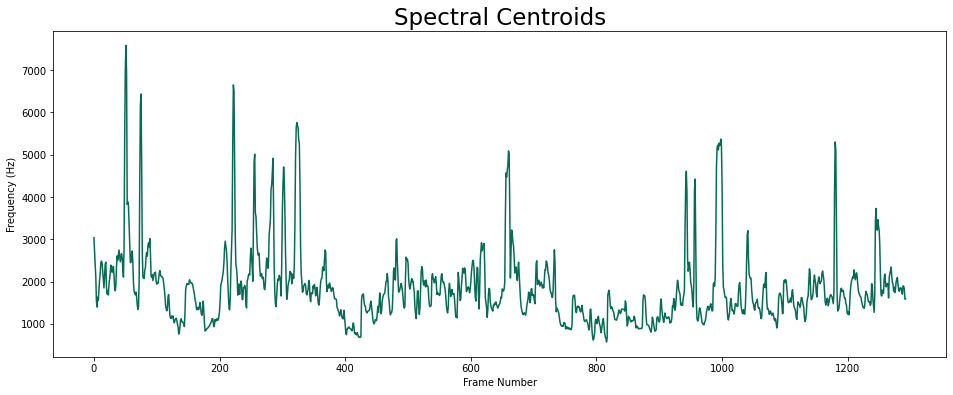

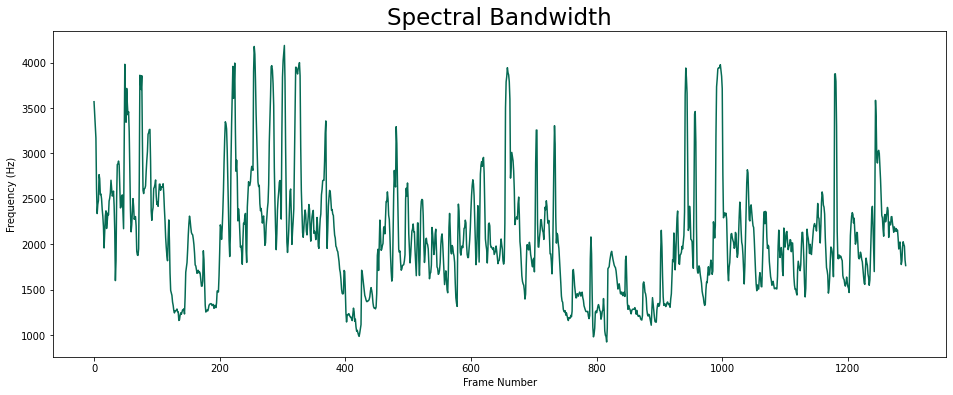

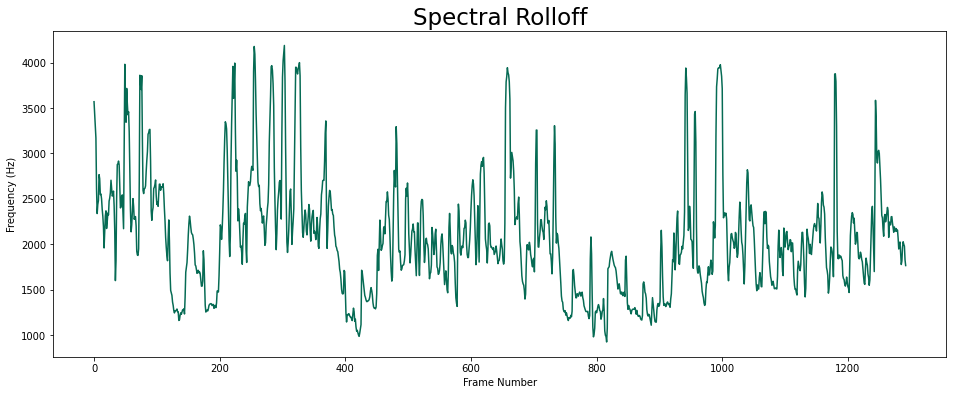

[Text(0, 0.5, 'Frequency Bands')]

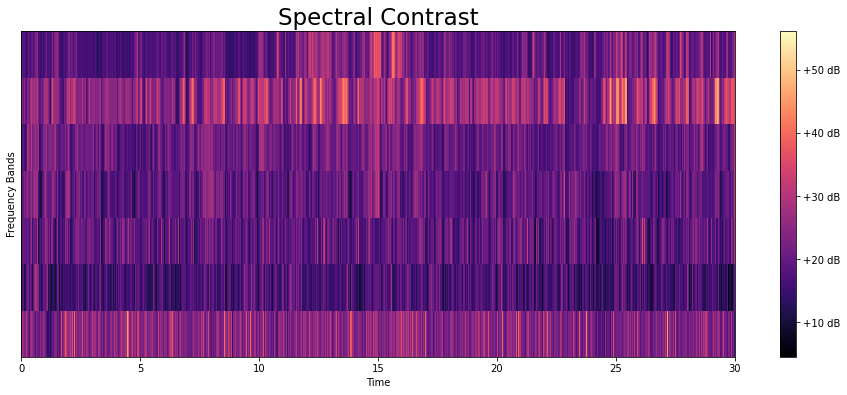

In [14]:
# Spectral Centroids
plt.figure(figsize = (16, 6))
plt.plot(librosa.feature.spectral_centroid(data, sr = sr)[0], color = "#066B54")
plt.xlabel('Frame Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroids', fontsize = 23)
plt.show()

# Spectral Bandwith
plt.figure(figsize = (16, 6))
spec_bw = librosa.feature.spectral_bandwidth(data, sr = sr)[0]
plt.xlabel('Frame Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Bandwidth', fontsize = 23)
plt.plot(spec_bw, color = "#066B54")
plt.show()

# Spectral Rolloff
plt.figure(figsize = (16, 6))
spec_ro = librosa.feature.spectral_rolloff(data, sr = sr)
plt.xlabel('Frame Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Rolloff', fontsize = 23)
plt.plot(spec_bw, color = "#066B54")
plt.show()

# Spectral Contrast
contrast = librosa.feature.spectral_contrast(S = np.abs(stft), sr = sr)

fig, ax = plt.subplots(figsize=(16,6))
img2 = librosa.display.specshow(contrast, x_axis = 'time', ax = ax)
fig.colorbar(img2, ax = ax, format = '%+1.0f dB')
plt.title('Spectral Contrast', fontsize = 23)
ax.set(ylabel = 'Frequency Bands')

#### **3. Mel-Frequency Cepstral Coefficients (MFCC)**

MFCC Shape	: (20, 1293)


Text(0.5, 1.0, 'MFCC in Pop 03')

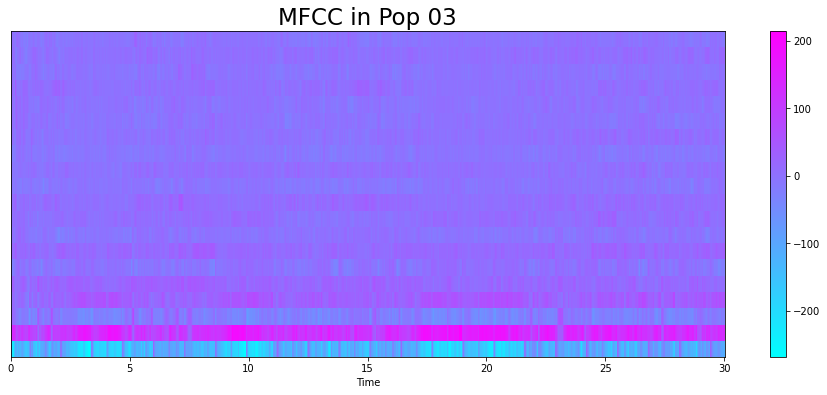

In [15]:
# Konversi ke MFCC
mfccs = librosa.feature.mfcc(data, sr = sr)
print('MFCC Shape\t:', mfccs.shape)

# Menampilkan MFCCs
fig, ax = plt.subplots(figsize = (16, 6))
img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax, cmap = 'cool')
fig.colorbar(img, ax=ax)
plt.title('MFCC in Pop 03', fontsize = 23)

#### **5. Chroma Feature**

Chromagram Shape	: (12, 1293)


Text(0.5, 1.0, 'Chromagram')

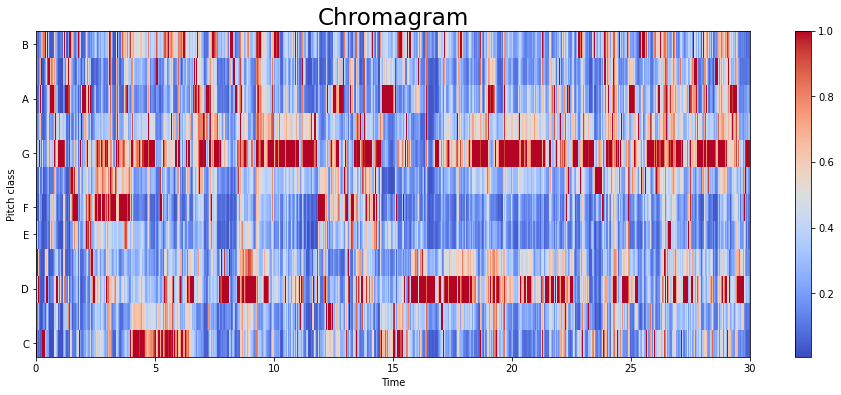

In [16]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y=data, sr = sr)
print('Chromagram Shape\t:', chromagram.shape)

# Menampilkan Chromagram
fig, ax = plt.subplots(figsize=(16, 6))
img = librosa.display.specshow(chromagram, x_axis = 'time', y_axis = 'chroma', cmap = 'coolwarm')
fig.colorbar(img, ax=ax)
plt.title('Chromagram', fontsize = 23)

## **4. Extraksi Fitur Untuk Klasifikasi Menggunakan MFCC**

In [17]:
# Function untuk melakukan ektraksi fitur mfcc per file
def mfcc_features(data):
  audio, sample_rate = librosa.load(data_name, res_type='kaiser_best')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)

  return mfccs_scaled_features

In [18]:
# Iterasi ekstraksi fitur keseluruhan dataset genre dengan MFCC

extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    try:
        final_class_labels = row["label"]
        data_name = os.path.join(os.path.abspath(audio_data), final_class_labels+'/', str(row["filename"]))    
        data = mfcc_features(data_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

553it [01:10, 11.77it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
557it [01:11,  5.28it/s]

Error: 


1000it [01:50,  9.03it/s]


In [19]:
# Konversi array extracted_features ke Pandas dataframe
df = pd.DataFrame(extracted_features, columns=['feature','class'])
df.head()

,feature,class
0,"[-113.57065, 121.57179, -19.168142, 42.36642, ...",blues
1,"[-207.5017, 123.991264, 8.955127, 35.87765, 2....",blues
2,"[-90.722595, 140.4463, -29.09389, 31.684334, -...",blues
3,"[-199.5442, 150.09091, 5.6626782, 26.85908, 1....",blues
4,"[-160.3377, 126.219635, -35.58781, 22.148071, ...",blues


In [20]:
# Informasi tabel ekstraksi fitur
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  999 non-null    object
 1   class    999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


In [21]:
# Menghitung jumlah data per class
df['class'].value_counts()

pop          100
country      100
metal        100
blues        100
disco        100
reggae       100
classical    100
hiphop       100
rock         100
jazz          99
Name: class, dtype: int64

In [22]:
# Independent dataset
X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

In [23]:
print('X shape\t:', X.shape)
print('y shape\t:', y.shape)

X shape	: (999, 40)
y shape	: (999,)


## **5. Klasifikasi Genre**

### **5.1 Data Preparation**

#### **1. Encoding Label Genre**

In [24]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [25]:
print('y shape after encode label :', y.shape)

y shape after encode label : (999, 10)


#### **2. Splitting Data Train dan Test**

In [26]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [27]:
print(f"X_train\t{X_train.shape}")
print(f"X_test\t{X_test.shape}")
print(f"y_train\t{y_train.shape}")
print(f"y_test\t{y_test.shape}")

X_train	(799, 40)
X_test	(200, 40)
y_train	(799, 10)
y_test	(200, 10)


### **5.2 Model Building Using Deep Learning**

In [28]:
# Model build deep learning
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))

# Final Layer
model.add(Dense(10, activation='softmax'))  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [29]:
# Compile Model
model.compile(optimizer = 'adam',
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [30]:
# Callback Function
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.70:
      self.model.stop_training = True

In [31]:
# Fit Model
history = model.fit(X_train, y_train,
                 validation_data = (X_test, y_test),
                 epochs = 1000,
                 batch_size = 64,
                 callbacks = Callback())

Epoch 1/1000
13/13 [==============================] - 3s 29ms/step - loss: 4.9079 - accuracy: 0.1702 - val_loss: 2.0695 - val_accuracy: 0.2750
Epoch 2/1000
13/13 [==============================] - 0s 9ms/step - loss: 2.4383 - accuracy: 0.2528 - val_loss: 1.8826 - val_accuracy: 0.3250
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 2.0661 - accuracy: 0.3191 - val_loss: 1.7855 - val_accuracy: 0.3200
Epoch 4/1000
13/13 [==============================] - 0s 8ms/step - loss: 1.8416 - accuracy: 0.3554 - val_loss: 1.6715 - val_accuracy: 0.3900
Epoch 5/1000
13/13 [==============================] - 0s 9ms/step - loss: 1.8256 - accuracy: 0.3367 - val_loss: 1.6822 - val_accuracy: 0.4050
Epoch 6/1000
13/13 [==============================] - 0s 9ms/step - loss: 1.6745 - accuracy: 0.3917 - val_loss: 1.5554 - val_accuracy: 0.4100
Epoch 7/1000
13/13 [==============================] - 0s 9ms/step - loss: 1.5629 - accuracy: 0.4243 - val_loss: 1.4911 - val_accuracy: 0.4100
Epoch

Max. Validation Accuracy 0.7049999833106995


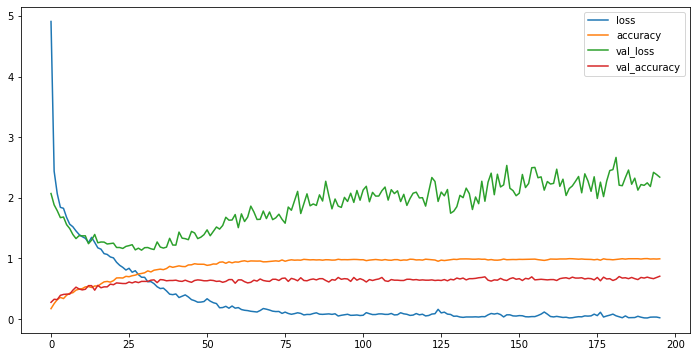

In [32]:
print("Max. Validation Accuracy", max(history.history["val_accuracy"]))

# Plot akurasi dan loss
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.legend()
plt.savefig('plot_akurasi.png')
plt.show()

### **5.3 Model Evaluation**

In [33]:
# Model evaluasi
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Test\t:", test_loss)
print("Accuracy Test\t:", test_acc*100)

2/2 [==============================] - 0s 8ms/step - loss: 2.3395 - accuracy: 0.7050
Loss Test	: 2.339529037475586
Accuracy Test	: 70.49999833106995


### **5.4 Testing Model**

In [34]:
# Model Predict
y_predict = np.argmax(model.predict(X_test), axis=-1)
y_predict

array([7, 0, 0, 6, 9, 5, 3, 4, 0, 5, 6, 2, 3, 8, 9, 9, 2, 3, 3, 2, 6, 4,
       5, 0, 1, 2, 0, 2, 4, 3, 6, 2, 3, 6, 7, 7, 0, 8, 1, 3, 9, 5, 6, 0,
       2, 8, 7, 9, 3, 8, 3, 9, 3, 1, 8, 4, 4, 2, 8, 5, 8, 6, 5, 9, 7, 8,
       5, 8, 0, 8, 5, 8, 8, 3, 9, 4, 6, 4, 6, 2, 6, 0, 6, 5, 9, 9, 5, 3,
       2, 7, 9, 8, 8, 5, 2, 6, 9, 4, 5, 0, 1, 5, 6, 6, 7, 5, 1, 0, 5, 5,
       8, 1, 8, 4, 0, 9, 7, 9, 9, 5, 0, 4, 8, 6, 3, 0, 2, 4, 6, 3, 7, 4,
       7, 3, 0, 3, 8, 1, 7, 2, 8, 5, 6, 9, 4, 0, 0, 1, 0, 5, 3, 9, 7, 5,
       8, 2, 8, 3, 6, 4, 1, 5, 1, 5, 7, 9, 8, 7, 1, 0, 3, 8, 3, 3, 4, 1,
       7, 4, 5, 8, 2, 3, 3, 3, 3, 8, 9, 4, 8, 0, 6, 6, 7, 8, 6, 1, 2, 8,
       3, 4])

In [35]:
# Input path audio yang akan di test
filename = "/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"

# Librosa load
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# MFCC Fitur Inputan Audio
mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print('\n', mfccs_scaled_features)
print('\n', mfccs_scaled_features.shape)

predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis = -1)
print("Label Genre\t:", predicted_label)

prediction_class = labelencoder.inverse_transform(predicted_label) 
print("Prediksi Genre\t:", prediction_class)

[-1.1357065e+02  1.2157179e+02 -1.9168142e+01  4.2366421e+01
 -6.3646641e+00  1.8623499e+01 -1.3704891e+01  1.5343150e+01
 -1.2274110e+01  1.0976572e+01 -8.3265734e+00  8.8037930e+00
 -3.6723001e+00  5.7479949e+00 -5.1628819e+00  7.5273985e-01
 -1.6902149e+00 -4.0897894e-01 -2.3035226e+00  1.2212901e+00
 -3.5343504e+00 -1.1414334e+00 -4.2830324e+00 -4.2261953e+00
  9.1561663e-01  9.1268736e-01 -5.7613473e+00 -3.9327433e+00
  1.5108240e+00  2.6988823e+00  5.6574712e+00 -3.2662375e+00
 -2.0303418e-01 -3.0002940e+00  4.4772325e+00 -4.7590593e-01
  6.0092382e+00 -5.8892559e-02 -3.4585075e+00 -1.8423905e+00]

 [[-1.1357065e+02  1.2157179e+02 -1.9168142e+01  4.2366421e+01
  -6.3646641e+00  1.8623499e+01 -1.3704891e+01  1.5343150e+01
  -1.2274110e+01  1.0976572e+01 -8.3265734e+00  8.8037930e+00
  -3.6723001e+00  5.7479949e+00 -5.1628819e+00  7.5273985e-01
  -1.6902149e+00 -4.0897894e-01 -2.3035226e+00  1.2212901e+00
  -3.5343504e+00 -1.1414334e+00 -4.2830324e+00 -4.2261953e+00
   9.1561663e-0

## **6. Save Model**

In [36]:
# Save Model
model.save('model.h5')

## **7. Convert Model**

In [37]:
# Install tensorflowjs
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.1 MB/s 


In [38]:
# Mengubah model.h5 kebentuk JSON
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

## 8. Filtering Lagu Berdasarkan Genre

### 8.1 Mengubah genre yang didapat dari model klasifikasi ke dalam bentuk list

In [48]:
prediction_class = str(prediction_class[0])
prediction_class = list(prediction_class)

### 8.2 Download Dataset

In [40]:
od.download("https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aldysp34
Your Kaggle Key: ··········


100%|██████████| 19.3k/19.3k [00:00<00:00, 5.22MB/s]

### 8.3 Explore Dataset

In [41]:
spotify_df = pd.read_csv("/content/top-spotify-songs-from-20102019-by-year/top10s.csv", encoding='mac_roman')
spotify_df.head()

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [42]:
print("*Jumlah kolom dan index*")
print(f"Index : {spotify_df.shape[0]}\n Kolom : {spotify_df.shape[1]}")
print("\n")
print("*Kolom pada dataframe*")
print(spotify_df.columns)
print("\n")
print("*Info pada kolom*")
print(spotify_df.info())
print("\n")
print("*Info dataframe*")
print(spotify_df.describe())

*Jumlah kolom dan index*
Index : 603
 Kolom : 15


*Kolom pada dataframe*
Index(['Unnamed: 0', 'title', 'artist', 'top genre', 'year', 'bpm', 'nrgy',
       'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop'],
      dtype='object')


*Info pada kolom*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  603 non-null    int64 
 1   title       603 non-null    object
 2   artist      603 non-null    object
 3   top genre   603 non-null    object
 4   year        603 non-null    int64 
 5   bpm         603 non-null    int64 
 6   nrgy        603 non-null    int64 
 7   dnce        603 non-null    int64 
 8   dB          603 non-null    int64 
 9   live        603 non-null    int64 
 10  val         603 non-null    int64 
 11  dur         603 non-null    int64 
 12  acous       603 non-null    int64 
 13  spch        603 non-null    in

In [43]:
print(spotify_df.isnull().sum())

Unnamed: 0    0
title         0
artist        0
top genre     0
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
dtype: int64


In [44]:
spotify_df.drop(['bpm', 'nrgy','pop','dnce','dB','live','val','dur','acous','spch'], axis=1, inplace=True)

In [45]:
spotify_df.head()

,Unnamed: 0,title,artist,top genre,year
0,1,"Hey, Soul Sister",Train,neo mellow,2010
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010
2,3,TiK ToK,Kesha,dance pop,2010
3,4,Bad Romance,Lady Gaga,dance pop,2010
4,5,Just the Way You Are,Bruno Mars,pop,2010


In [46]:
spotify_df.rename(columns={'Unnamed: 0' : 'music_id'}, inplace=True )

### 8.4 Filtering Data

In [49]:
filtering_df = pd.DataFrame(spotify_df.loc[spotify_df['top genre'].isin(prediction_class)])